# Import Modules

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay
from typing import Tuple, List

In [2]:
SEED = 42
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
set_seed(SEED)

# Load Dataset

In [3]:
from google.colab import files
f = files.upload()

Saving Cora.zip to Cora.zip


In [4]:
!unzip Cora.zip

Archive:  Cora.zip
  inflating: Cora/edge.pt            
  inflating: Cora/feat.pt            
  inflating: Cora/label.pt           


In [12]:
features: torch.Tensor = torch.load('./Cora/feat.pt')
edges: torch.Tensor = torch.load('./Cora/edge.pt')
labels: torch.Tensor = torch.load('./Cora/label.pt')

num_nodes = features.shape[0]
feat_dim = features.shape[1]
num_edges = edges.shape[1]
num_classes = labels.max().item()+1

print("Number of Total Nodes : ", num_nodes)
print("Number of Total Edges : ", num_edges)
print("Dimension of Node Features : ", feat_dim)
print("Number of Classes : ", num_classes)

count = 0
#print(features[0][1] == 0)

#if (features[0][1] == 0):
 #   print("dkjf")

for i in range(10):
    for j in range(feat_dim):
        if(features[i][j] != 0):
            count += 1
    print("data {} : {}".format(i, count))
    count = 0

#1 0 0 0  ,... 0 ->

Number of Total Nodes :  2708
Number of Total Edges :  10556
Dimension of Node Features :  1433
Number of Classes :  7
data 0 : 9
data 1 : 23
data 2 : 19
data 3 : 21
data 4 : 18
data 5 : 13
data 6 : 18
data 7 : 14
data 8 : 20
data 9 : 3


# Set Hyperparameters

In [ ]:
hyperparameters_GAT = {
    "emb_dim": 8,
    "dropout": 0.6,
    "alpha": 0.2,
    "num_heads": 8,
    "lr": 0.01,
    "weight_decay": 5e-4
}

hyperparameters_GATv2 = {
    "emb_dim": 8,
    "dropout": 0.6,
    "alpha": 0.2,
    "num_heads": 8,
    "lr": 0.01,
    "weight_decay": 5e-4
}

hyperparameters = {
    "GAT": hyperparameters_GAT,
    "GATv2": hyperparameters_GATv2,
    "Training": {
        "num_epochs": 200,
        "train_ratio": 0.8,
        "val_ratio": 0.1
    }
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Split Indices to train-valid-test

In [ ]:
def split_index(num_nodes: int, train_ratio: float, val_ratio: float,
                seed: int=SEED) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    num_train = int(train_ratio * num_nodes)
    num_val = int(val_ratio * num_nodes)
    num_test = num_nodes - num_train - num_val

    rng = np.random.default_rng(seed)
    index = np.arange(num_nodes)
    rng.shuffle(index)

    idx_train = index[:num_train]
    idx_valid = index[num_train:num_train+num_val]
    idx_test = index[-num_test:]

    return idx_train, idx_valid, idx_test

In [ ]:
train_ratio = hyperparameters["Training"]["train_ratio"]
val_ratio = hyperparameters["Training"]["val_ratio"]

idx_train, idx_val, idx_test = split_index(num_nodes, train_ratio, val_ratio, SEED)
print("Number of Train Nodes : ", idx_train.shape[0])
print("Number of Validation Nodes : ", idx_val.shape[0])
print("Number of Test Nodes : ", idx_test.shape[0])

Number of Train Nodes :  2166
Number of Validation Nodes :  270
Number of Test Nodes :  272


# Generate GAT Layer

In [ ]:
class GATLayer(nn.Module):

    def __init__(self, in_dim: int,
                 out_dim: int,
                 activation=lambda x: x,
                 dropout: float= 0.5,
                 alpha: float= 0.2) -> None:

        super(GATLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.activation = activation
        self.dropout = dropout
        self.alpha = alpha

        self.W = nn.Parameter(torch.empty(size=(in_dim, out_dim)))
        nn.init.xavier_uniform_(self.W.data)
        self.a = nn.Parameter(torch.empty(size=(2*out_dim, 1)))
        nn.init.xavier_uniform_(self.a.data)

        self.leakyrelu = nn.LeakyReLU(negative_slope=self.alpha)

    def forward(self, feat: torch.Tensor,
                edges: torch.Tensor) -> torch.Tensor:
        '''
            - feat: [num_nodes, in_dim]
            - edges: [2, num_edges]
            - out: [num_nodes, out_dim]
        '''
        message = feat @ self.W
        attn_src = message @ self.a[:self.out_dim, :]
        attn_dst = message @ self.a[self.out_dim:, :]

        src, dst = edges
        attn_scores = self.leakyrelu(attn_src[src] + attn_dst[dst])
        attn_scores = attn_scores - attn_scores.max()

        exp_sum = torch.zeros((feat.shape[0], 1), device = feat.device).scatter_add_(
            dim = 0, index = dst.unsqueeze(1), src = attn_scores.exp())
        attn_coeffs = attn_scores.exp() / exp_sum[dst]
        attn_coeffs = F.dropout(attn_coeffs, self.dropout, training = self.training)

        out = torch.zeros_like(message, device = feat.device).scatter_add_(
            dim = 0, index = dst.repeat((self.out_dim, 1)).T, src = message[src]*attn_coeffs)
        out = self.activation(out)

        return out

In [ ]:
class GAT(nn.Module):

    def __init__(self, feat_dim: int,
                 emb_dim: int,
                 num_classes: int,
                 dropout: float=0.5,
                 alpha: float=0.2,
                 num_heads: int=8) -> None:

        super(GAT, self).__init__()
        self.dropout = dropout
        self.num_heads = num_heads

        self.attn_heads = nn.ModuleList([
            GATLayer(feat_dim,
                     emb_dim,
                     activation = nn.ELU(),
                     dropout = dropout,
                     alpha = alpha)
            for _ in range(num_heads)])

        self.attn_classifier = GATLayer(emb_dim*num_heads,
                                        num_classes,
                                        dropout = dropout,
                                        alpha = alpha)

    def forward(self, feat: torch.Tensor,
                edges: torch.Tensor) -> torch.Tensor:
        '''
            - feat: [num_nodes, in_dim]
            - edges: [2, num_edges]
            - out: [num_nodes, num_classes]
        '''

        feat = F.dropout(feat, self.dropout, training = self.training)
        h = torch.cat([att(feat, edges) for att in self.attn_heads], dim = 1)
        h = F.dropout(h, self.dropout, training = self.training)
        h = F.elu(self.attn_classifier(h, edges))
        out = F.log_softmax(h, dim = 1)

        return out

# Generate GATv2 Layer

In [ ]:
class GATv2Layer(nn.Module):

    def __init__(self, in_dim: int,
                 out_dim: int,
                 activation = lambda x: x,
                 dropout: float=0.5,
                 alpha: float=0.2) -> None:

        super(GATv2Layer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.activation = activation
        self.dropout = dropout
        self.alpha = alpha

        self.W_src = nn.Parameter(torch.empty(size=(in_dim, out_dim)))
        nn.init.xavier_uniform_(self.W_src.data)
        self.W_dst = nn.Parameter(torch.empty(size=(in_dim, out_dim)))
        nn.init.xavier_uniform_(self.W_dst.data)
        self.a = nn.Parameter(torch.empty(size=(out_dim, 1)))
        nn.init.xavier_uniform_(self.a.data)

        self.leakyrelu = nn.LeakyReLU(negative_slope=self.alpha)

    def forward(self, feat: torch.Tensor,
                edges: torch.Tensor) -> torch.Tensor:
        '''
            - feat: [num_nodes, in_dim]
            - edges: [2, num_edges]
            - out: [num_nodes, out_dim]
        '''

        message_src = feat @ self.W_src
        message_dst = feat @ self.W_dst

        src, dst = edges
        attn_scores = self.leakyrelu(message_src[src] + message_dst[dst]) @ self.a
        attn_scores = attn_scores - attn_scores.max()

        exp_sum = torch.zeros((feat.shape[0], 1), device = feat.device).scatter_add_(
            dim = 0, index = dst.unsqueeze(1), src = attn_scores.exp())
        attn_coeffs = attn_scores.exp() / exp_sum[dst]
        attn_coeffs = F.dropout(attn_coeffs, self.dropout, training = self.training)

        out = torch.zeros_like(message_src, device = feat.device).scatter_add_(
            dim = 0, index = dst.repeat((self.out_dim, 1)).T, src = message_src[src]*attn_coeffs)
        out = self.activation(out)

        return out

In [ ]:
class GATv2(nn.Module):

    def __init__(self, feat_dim: int,
                 emb_dim: int,
                 num_classes: int,
                 dropout: float=0.5,
                 alpha: float=0.2,
                 num_heads: int=8) -> None:

        super(GATv2, self).__init__()
        self.dropout = dropout
        self.num_heads = num_heads

        self.attn_heads = nn.ModuleList([
            GATv2Layer(feat_dim,
                       emb_dim,
                       activation = nn.ELU(),
                       dropout = dropout,
                       alpha = alpha)
            for _ in range(num_heads)])

        self.attn_classifier = GATv2Layer(emb_dim * num_heads,
                                          num_classes,
                                          dropout=dropout,
                                          alpha=alpha)

    def forward(self, feat: torch.Tensor,
                edges: torch.Tensor) -> torch.Tensor:
        '''
            - feat: [num_nodes, in_dim]
            - edges: [2, num_edges]
            - out: [num_nodes, num_classes]
        '''
        feat = F.dropout(feat, self.dropout, training = self.training)
        h = torch.cat([att(feat, edges) for att in self.attn_heads], dim = 1)
        h = F.dropout(h, self.dropout, training = self.training)
        h = F.elu(self.attn_classifier(h, edges))
        out = F.log_softmax(h, dim = 1)

        return out

# Define Train, Test Frameworks

In [ ]:
def train_one_epoch(model: nn.Module, optimizer: torch.optim.Optimizer,
                    features: torch.Tensor, edges: torch.Tensor,
                    labels: torch.Tensor, idx_train: np.ndarray) -> float:

    model.train()
    optimizer.zero_grad()

    out = model(features, edges)

    labels = torch.zeros((num_nodes, num_classes), device=labels.device).scatter_(
        dim = 1,
        index = labels.unsqueeze(1),
        value = 1)
    loss = F.cross_entropy(out[idx_train], labels[idx_train])

    loss.backward()
    optimizer.step()

    return float(loss.cpu())

@torch.no_grad()
def test(model: nn.Module, features: torch.Tensor, edges: torch.Tensor, labels: torch.Tensor,
         idx_train: np.ndarray, idx_val: np.ndarray, idx_test: np.ndarray) -> Tuple[List[float], torch.Tensor]:

    model.eval()
    pred = model(features, edges).argmax(dim=-1)

    accs = []
    for data in [idx_train, idx_val, idx_test]:
        accs.append(int((pred[data] == labels[data]).sum()) / int(data.shape[0]))

    return accs, pred.cpu()

def train(num_epochs: int, model: nn.Module, optimizer: torch.optim.Optimizer,
          features: torch.Tensor, edges: torch.Tensor,
          labels: torch.Tensor, idx_train: np.ndarray) -> Tuple[torch.Tensor, List[float], List[float], List[float]]:

    best_epoch = 0
    best_val_acc = best_test_acc = 0.
    best_pred = None
    train_accs, valid_accs, test_accs = [], [], []

    with tqdm(range(1, num_epochs + 1), unit="epoch", desc="Training") as pbar:

        pbar.clear()
        for epoch in pbar:
            loss = train_one_epoch(model, optimizer, features, edges, labels, idx_train)
            (train_acc, val_acc, test_acc), pred = test(model, features, edges, labels, idx_train, idx_val, idx_test)
            train_accs.append(train_acc)
            valid_accs.append(val_acc)
            test_accs.append(test_acc)

            if val_acc > best_val_acc:
                best_epoch = epoch
                best_val_acc = val_acc
                best_test_acc = test_acc
                best_pred = pred

            postfix_new = ", ".join([f"Acc. (Train): {train_acc:.4f}",
                                     f"Acc. (Val): {val_acc:.4f} (best: {best_val_acc:.4f})",
                                     f"Acc. (Test): {test_acc:.4f} (best: {best_test_acc:.4f})",
                                     f"loss: {loss:.4f}"])
            pbar.set_postfix_str(postfix_new)

        print(f"Best Epoch: {best_epoch}")
        print(f"Best Validation Accuracy: {best_val_acc:.4f}")
        print(f"Best Test Accuracy: {best_test_acc:.4f}")

    return best_pred, train_accs, valid_accs, test_accs

# Train Phase of GAT

In [ ]:
set_seed(SEED)

model = GAT(feat_dim,
            hyperparameters["GAT"]["emb_dim"],
            num_classes,
            hyperparameters["GAT"]["dropout"],
            hyperparameters["GAT"]["alpha"],
            hyperparameters["GAT"]["num_heads"]).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=hyperparameters["GAT"]["lr"],
                             weight_decay=hyperparameters["GAT"]["weight_decay"])

features = features.to(device)
edges = edges.to(device)
labels = labels.to(device)
num_epochs = hyperparameters["Training"]["num_epochs"]

best_pred, train_accs, valid_accs, test_accs = train(num_epochs, model, optimizer, features, edges, labels, idx_train)

Training: 100%|██████████| 200/200 [00:16<00:00, 12.29epoch/s, Acc. (Train): 0.9340, Acc. (Val): 0.8815 (best: 0.9000), Acc. (Test): 0.8676 (best: 0.8787), loss: 0.9357]

Best Epoch: 64
Best Validation Accuracy: 0.9000
Best Test Accuracy: 0.8787


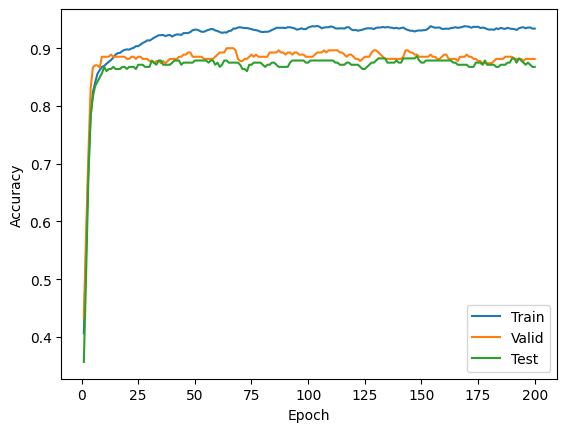

In [ ]:
x = np.arange(1, num_epochs+1)
plt.plot(x, train_accs, label='Train')
plt.plot(x, valid_accs, label='Valid')
plt.plot(x, test_accs, label='Test')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

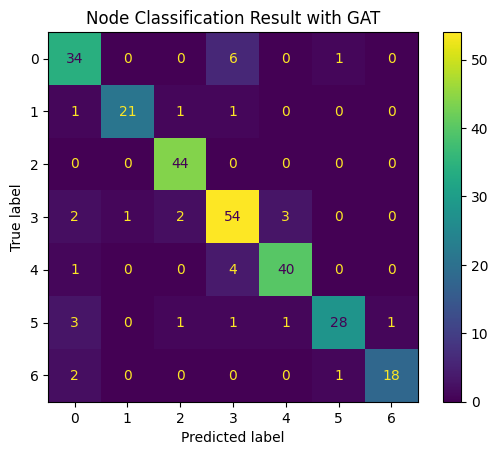

In [ ]:
best_pred = best_pred.cpu()
labels = labels.cpu()

ConfusionMatrixDisplay.from_predictions(labels[idx_test], best_pred[idx_test])
plt.title("Node Classification Result with GAT")
plt.show()

# Train Phase of GATv2

In [ ]:
set_seed(SEED)

model = GATv2(feat_dim,
            hyperparameters["GATv2"]["emb_dim"],
            num_classes,
            hyperparameters["GATv2"]["dropout"],
            hyperparameters["GATv2"]["alpha"],
            hyperparameters["GATv2"]["num_heads"]).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=hyperparameters["GATv2"]["lr"],
                             weight_decay=hyperparameters["GATv2"]["weight_decay"])

features = features.to(device)
edges = edges.to(device)
labels = labels.to(device)
num_epochs = hyperparameters["Training"]["num_epochs"]

best_pred, train_accs, valid_accs, test_accs = train(num_epochs, model, optimizer, features, edges, labels, idx_train)

Training: 100%|██████████| 200/200 [00:11<00:00, 17.41epoch/s, Acc. (Train): 0.9367, Acc. (Val): 0.8815 (best: 0.8963), Acc. (Test): 0.8750 (best: 0.8824), loss: 0.9511]

Best Epoch: 65
Best Validation Accuracy: 0.8963
Best Test Accuracy: 0.8824


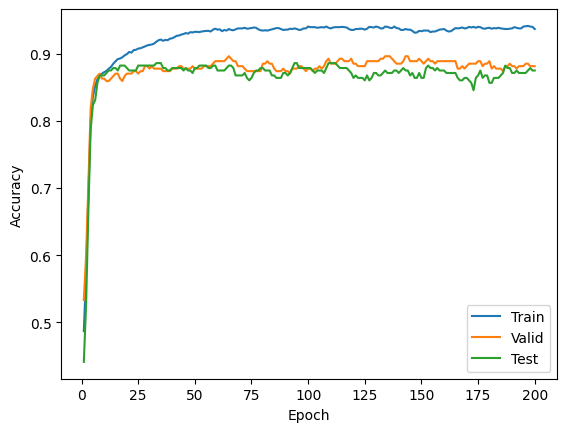

In [ ]:
x = np.arange(1, num_epochs+1)
plt.plot(x, train_accs, label='Train')
plt.plot(x, valid_accs, label='Valid')
plt.plot(x, test_accs, label='Test')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

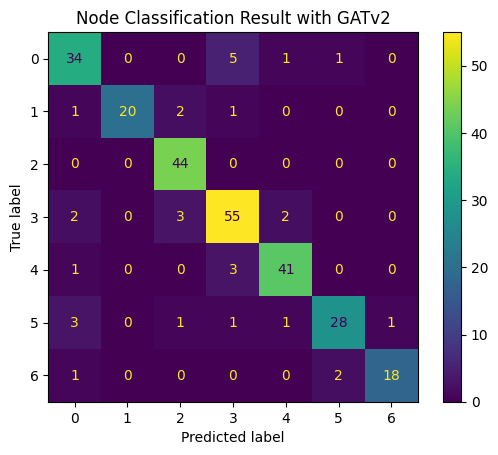

In [ ]:
best_pred = best_pred.cpu()
labels = labels.cpu()

ConfusionMatrixDisplay.from_predictions(labels[idx_test], best_pred[idx_test])
plt.title("Node Classification Result with GATv2")
plt.show()